In [1]:
from itertools import chain
from functools import reduce

import pandas as pd
import numpy as np
from sklearn.manifold import MDS
import scipy

from matplotlib.colors import LinearSegmentedColormap
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

AAs = 'ACDEFGHIKLMNPQRSTVWY-'
WT = "MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE"

models = ['LR', 'FCN', 'CNN0', 'CNN1', 'CNN2', 'GCN', 'EnsM', 'EnsC']
colors = {'LR':'#F57685', 'FCN':'#B51D49', 'CNN0':'#47A2F7','CNN1':'#47A2F7',
          'CNN2':'#47A2F7', 'GCN':'#6561B8', 'EnsM':'#56AC9D', 'EnsC':'#11677E'}
bcolor = '#E1E2E5'

In [2]:
df = pd.read_csv("designs.csv", index_col=0)
for model in models:
    mod1 = [m==model for m in df.model]
    mod2 = [(len(str(m))>4) and (model in m) for m in df.model] # To catch few cases where multiple models designed same sequence "['fcn', 'lr', 'lcb'], indices of replicate sequences: [31, 93, 192]"
    df[model] = [any((mod1[i],mod2[i])) for i in range(len(mod1))]

designs_df = df.loc[df.num_mut > 2]

lib10 = designs_df[designs_df.num_mut == 10]

In [3]:
def hamming_dist(seq1, seq2):
    return sum([1 for aa1, aa2 in zip(seq1, seq2) if aa1!=aa2])

In [4]:
lib_hds = []
for seq1 in designs_df.seq:
    lib_hds.append(np.array([hamming_dist(seq1, seq2) for seq2 in designs_df.seq]))
lib_hds = np.vstack(lib_hds)
embedding = MDS(n_components=2, dissimilarity='precomputed', n_init=4, max_iter=300, random_state=42)
transformed = embedding.fit_transform(lib_hds)

mds_df = designs_df.loc[:, models+['num_mut']].copy()
mds_df['mds_x'] = transformed[:,0]
mds_df['mds_y'] = transformed[:,1]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


/var/folders/br/jdgbwwhs7rvbmxy0x1kn6yd00000gn/T/ipykernel_41718/3842179747.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  boner_cmap = matplotlib.cm.get_cmap('bone_r')


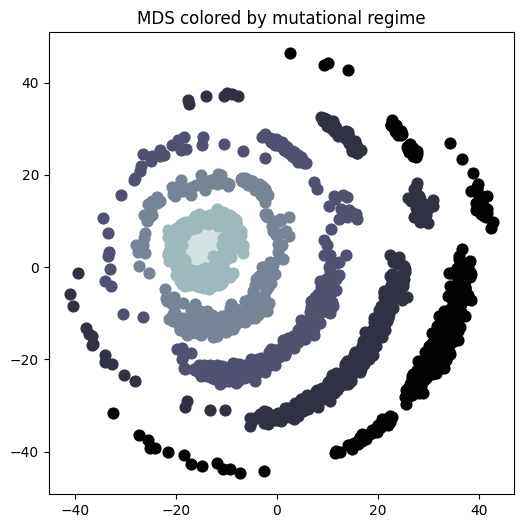

In [5]:
# fig 2b
boner_cmap = matplotlib.cm.get_cmap('bone_r')
dis_colors = [boner_cmap(.13), boner_cmap(.3), boner_cmap(.47), boner_cmap(.64), boner_cmap(.78), boner_cmap(.99)]

plt.figure(figsize=(6,6))
for m, c in zip([5,10,20,30,40,50], dis_colors):
    subset = mds_df[mds_df.num_mut == m]
    x, y = subset.mds_x, subset.mds_y
    plt.scatter(x,y, s=60, color=c)
plt.title('MDS colored by mutational regime')
plt.savefig('plots/gb1_library_nummut.svg', format='svg')

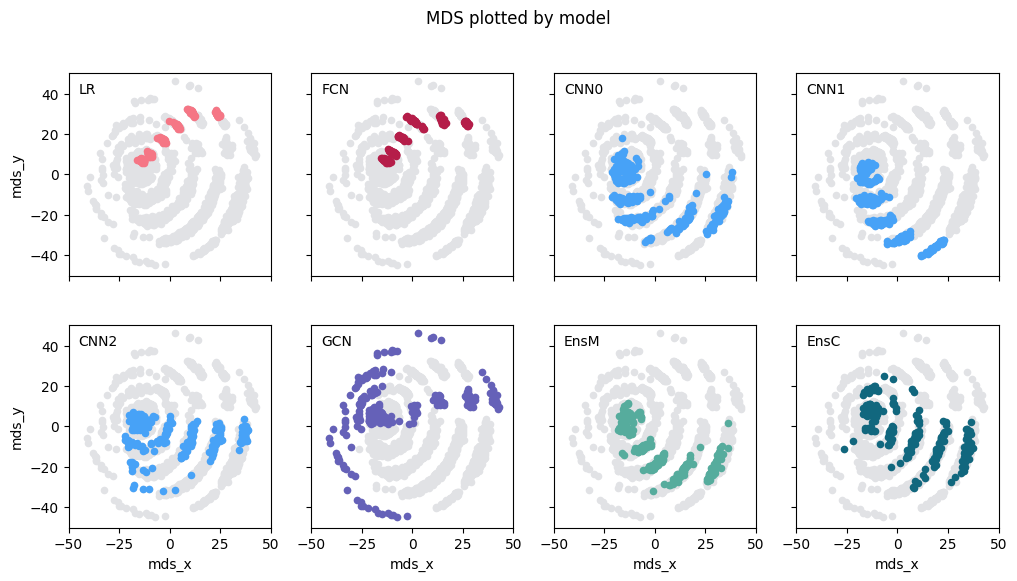

In [6]:
# fig 2c
fig, axs = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(12,6))

for i, (ax, model) in enumerate(zip(axs.flatten(), models)):
    ax.set_ylim((-50, 50))
    ax.set_xlim((-50, 50))

    # plot whole library in grey
    sns.scatterplot(data=mds_df, x='mds_x', y='mds_y', color=bcolor, ax=ax, linewidth=0, s=30)

    # plot individual model conditions in specific color
    model_df = mds_df.loc[mds_df[model]]
    sns.scatterplot(data=model_df, x='mds_x', y='mds_y', color=colors[model], ax=ax, linewidth=0, s=30)

    ax.text(-45, 40, model)
    ax.set_aspect('equal', adjustable='box')
    fig.suptitle('MDS plotted by model')

plt.savefig('plots/gb1_library_models.svg', format='svg')

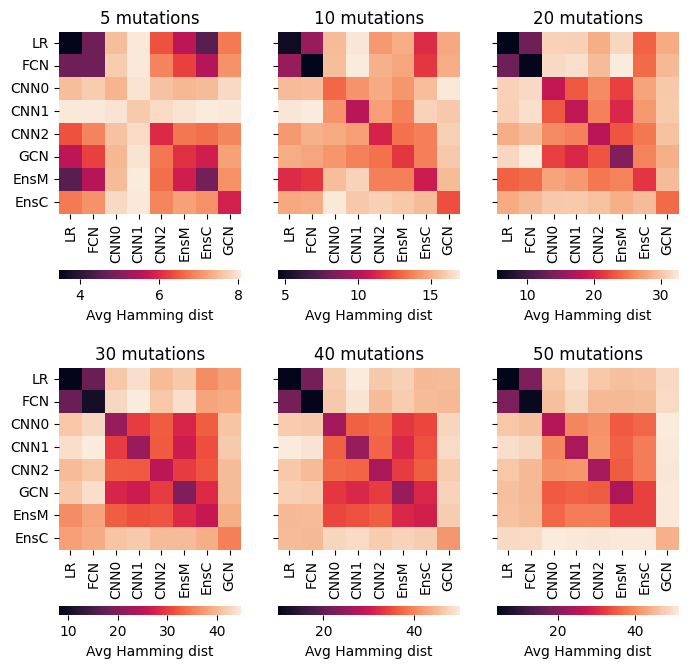

In [7]:
# fig s2
num_muts = [5, 10, 20, 30, 40, 50]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 8), sharey=True)

models_temp = ['LR', 'FCN', 'CNN0', 'CNN1', 'CNN2', 'EnsM', 'EnsC', 'GCN']

for i, num_mut in zip(range(len(num_muts)), num_muts):
    ax = axes[i//3,i%3]
    nmut_df = df.loc[df.num_mut == num_mut]
    seqs_by_model = [nmut_df.loc[df[model]].seq for model in models_temp]
    
    dist_matrix = []
    for seqs1 in seqs_by_model:
        avg_dists = []
        for seqs2 in seqs_by_model:
            avg_dists.append(sum(sum(hamming_dist(seq1, seq2) for seq1 in seqs1) for seq2 in seqs2)
                             / (len(seqs1)*len(seqs2)))
        dist_matrix.append(avg_dists)
    dist_matrix_df = pd.DataFrame(dist_matrix, index=models, columns=models_temp)
    sns.heatmap(dist_matrix_df, ax=ax, square=True, cbar_kws={'label': 'Avg Hamming dist', "orientation": "horizontal", 'pad':0.2})
    ax.set_title(f'{num_mut} mutations')
plt.savefig('plots/dist_matrix.png', dpi=300)

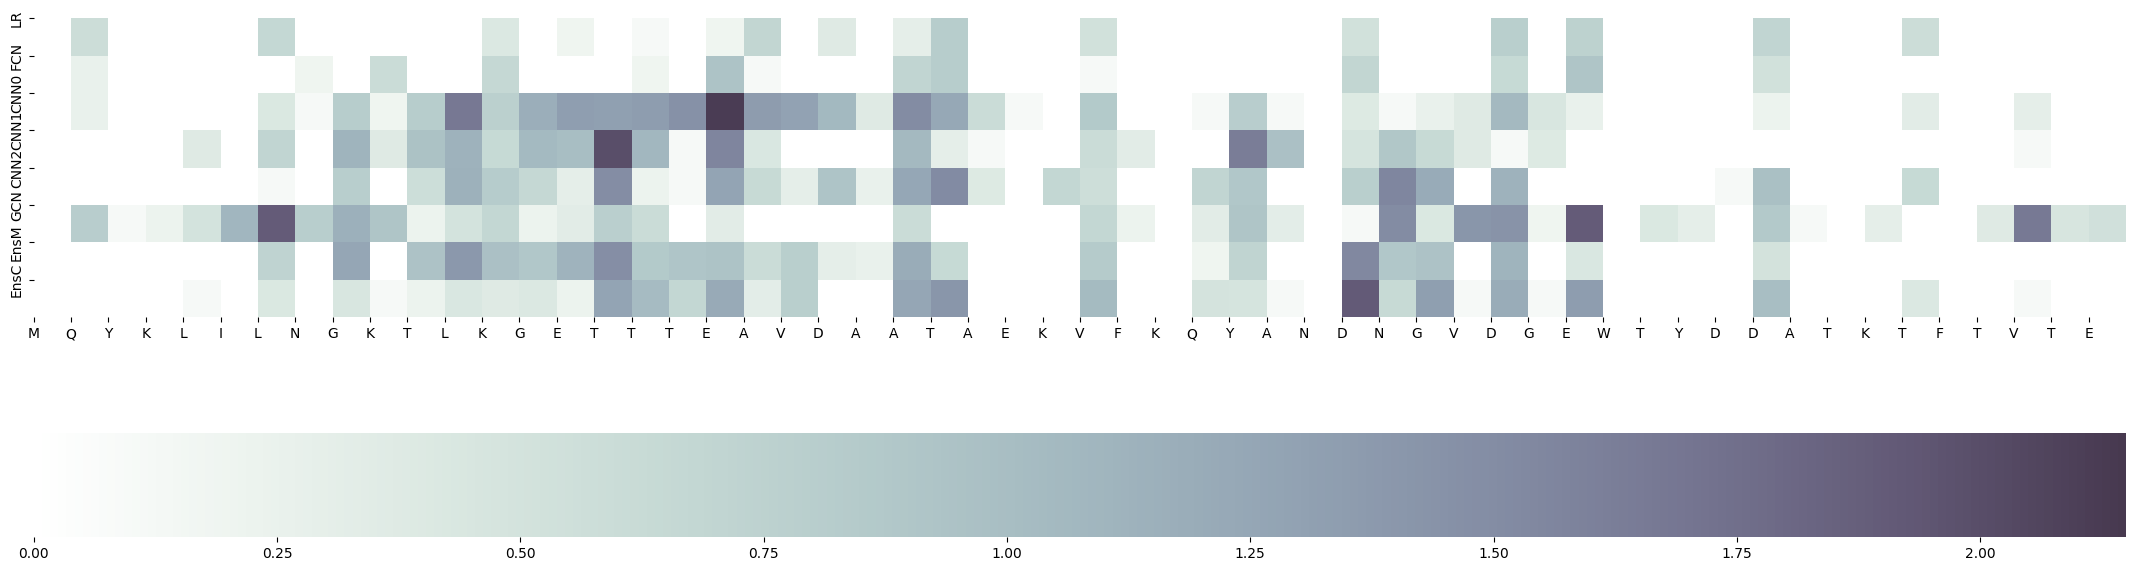

In [8]:
#fig 2d

def counts_to_probabilities(arr: np.ndarray):

    aa_dict = {aa:0 for aa in 'ACDEFGHIKLMNPQRSTVWY'}

    aas, counts = np.unique(arr, return_counts=True)
    counts = counts / counts.sum()

    aa_dict.update({aa:count for aa, count in zip(aas, counts)})

    return np.array(list(aa_dict.values()))


def sequence_entropy(seq_list: list[str], axis=1):

    seq_arr = np.vstack([np.array(list(s)) for s in seq_list])
    probabilities = np.vstack([counts_to_probabilities(i).T for i in seq_arr.T])

    # return probabilities
    return scipy.stats.entropy(probabilities, qk=None, base=None, axis=axis)

model_entropies = np.vstack([sequence_entropy(designs_df[(designs_df.num_mut == 10) & 
                                                         (designs_df[model])].seq.tolist()) for model in models])

custom_bonelike = LinearSegmentedColormap.from_list('palette', [[1.0, 1.0, 1.0],
 [0.9288068957722505, 0.9546925192067743, 0.9359270354015852],
 [0.8528706700407475, 0.9063097031737415, 0.8809675625807116],
 [0.7764937354167123, 0.8522542096435965, 0.8341061496377662],
 [0.7033204630045682, 0.7904748416674883, 0.7922087139026253],
 [0.6355933609625329, 0.7196837412447831, 0.7503954178432785],
 [0.5735128564149428, 0.6394164793558497, 0.7026010008568161],
 [0.5147052949134884, 0.5498780985827206, 0.6421932655887311],
 [0.45366975863152126, 0.4514715157919485, 0.5624124887995992],
 [0.3806401778011136, 0.343684732006475, 0.45604243853708415],
 [0.27705785742311567, 0.2217130205190177, 0.31176198544174705]])

plt.figure(figsize=(27,10))
sns.heatmap(model_entropies, square=True, cmap=custom_bonelike, cbar_kws={"orientation": "horizontal"}, cbar=True, vmax=2.15)
plt.xticks(list(range(len(WT))), list(WT))
plt.yticks(list(range(len(models))), models)

plt.show()

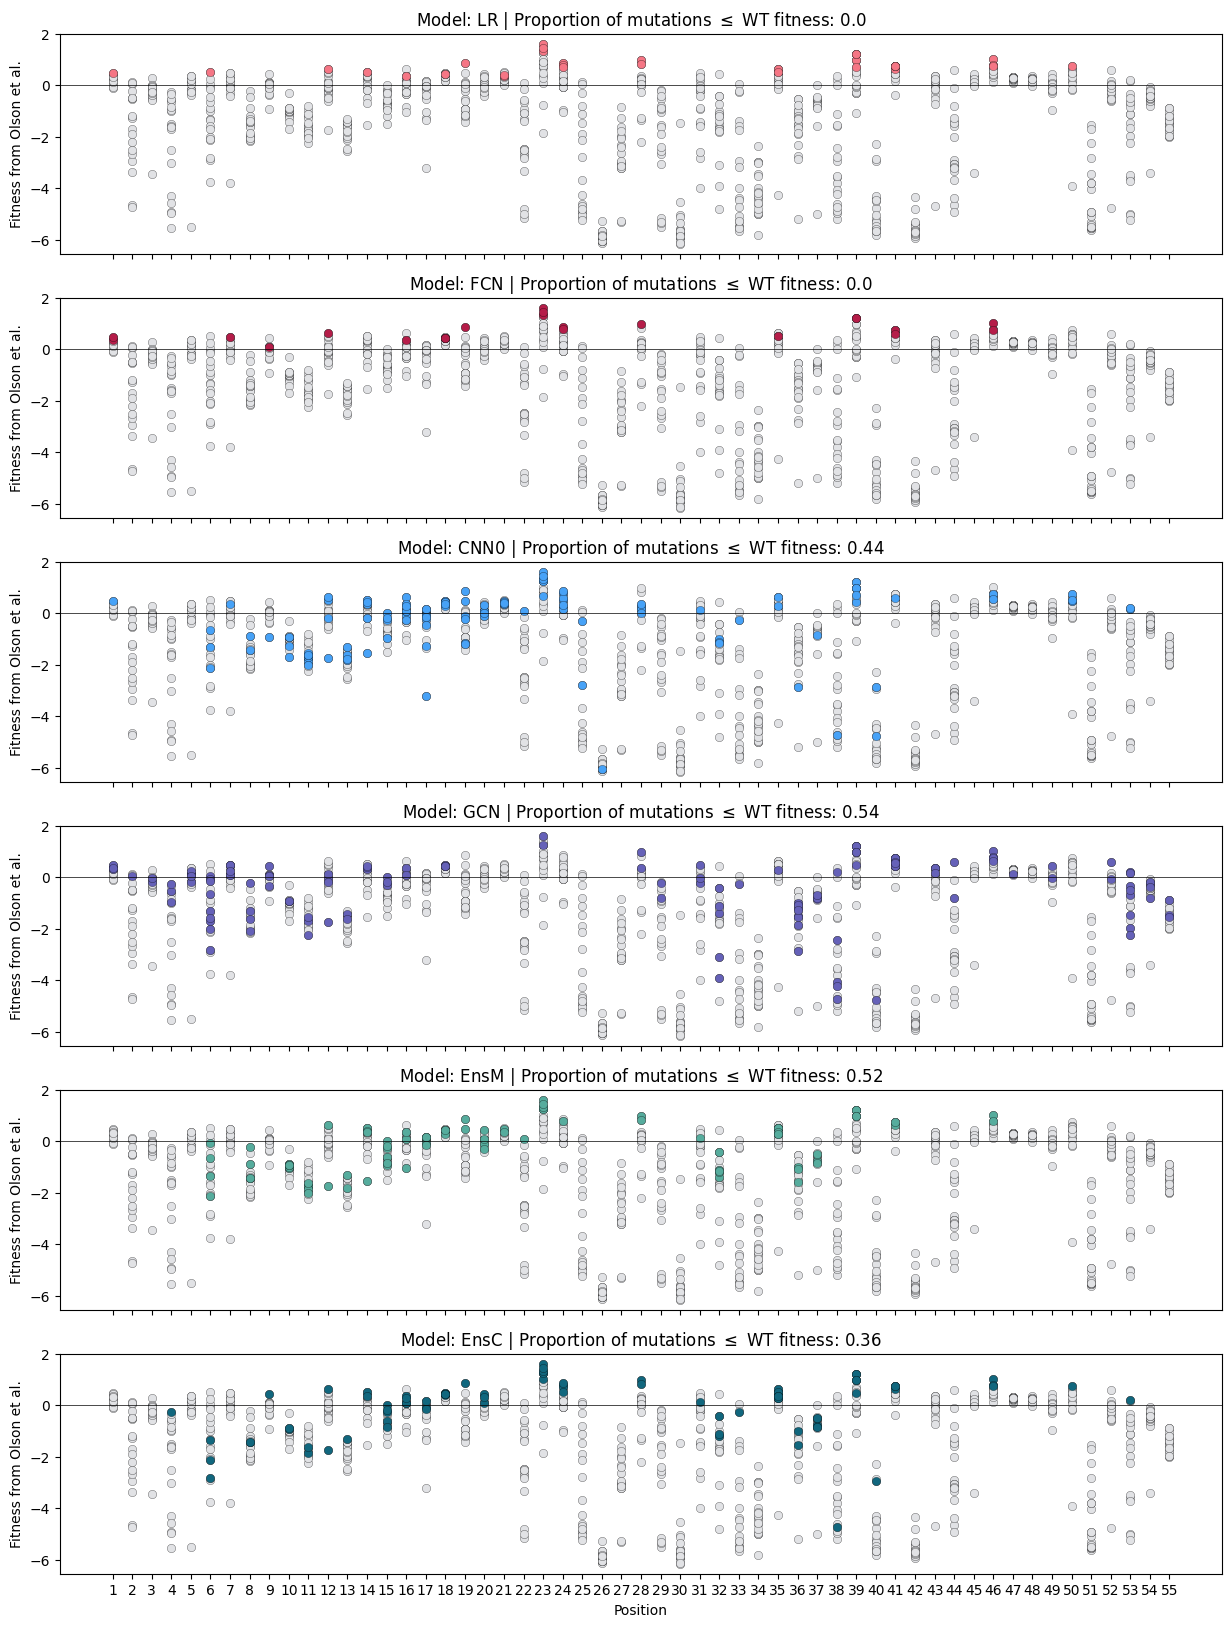

In [9]:
# fig s3
plots = ['LR', 'FCN', 'CNN0', 'GCN', 'EnsM', 'EnsC']

smuts = pd.read_csv('data/smut_fits_olson.csv', index_col=0)
smuts['position'] = [v[1:-1] for v in smuts.variant]
smuts.set_index('variant', inplace=True, drop=False)

def format_mutations(muts: str) -> list[str]:
    return "".join([m for m in muts if m not in " '()"]).split(',')

fig, axs = plt.subplots(len(plots), 1, figsize=(15, 20), sharex=True, sharey=True)

for model, ax in zip(plots, axs.flatten()):
    unique_mutants = list(set(list(chain(*[format_mutations(mutants) for mutants in 
                                           df[(df[model]) & (df.num_mut == 10)].mutations]))))
    mut_df = smuts.loc[unique_mutants]
    sns.scatterplot(data=smuts, x='position', y='score', ax=ax, color=bcolor, edgecolor='k', linewidth=0.2)
    sns.scatterplot(data=mut_df, x='position', y='score', ax=ax, color=colors[model], 
                    edgecolor='k', linewidth=0.2)
    ax.axhline(0, color='black', linewidth=0.5)
    
    ax.set_ylabel('Fitness from Olson et al.')
    ax.set_xlabel('Position')
    ax.set_title('Model: '+model+r' | Proportion of mutations $\leq$ WT fitness: '
                 +str(round(len([s for s in mut_df.score.tolist() if s <= 0]) / len(mut_df), 2)))
plt.savefig('plots/single_mutations.png', dpi=300)